In [1]:
# Needed for functions
import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np
import time

# Import Qiskit Classes
from qiskit import *
from qiskit import IBMQ
from qiskit import transpile
from qiskit.providers.aer import AerSimulator, QasmSimulator, noise
from qiskit.providers.aer.extensions import *
from qiskit import quantum_info as qi
from qiskit.test.mock import FakeMontreal, FakeToronto, FakeSydney
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
import qiskit.ignis.mitigation.measurement as mc

# Import Visualization Tools
from qiskit.tools.visualization import plot_histogram as plth
from qiskit.visualization import plot_state_city, plot_state_hinton
from qiskit.tools.monitor import job_monitor
from qiskit.tools.jupyter import *


In [2]:
IBMQ.load_account()
provider = IBMQ.get_provider('ibm-q')


In [3]:
fake_montreal = FakeMontreal()
qcomp_sim_M = AerSimulator.from_backend(fake_montreal)
fake_montreal

<FakeMontreal('fake_montreal') from None()>

In [4]:
fake_toronto = FakeToronto()
qcomp_sim_T = AerSimulator.from_backend(fake_toronto)
fake_toronto

<FakeToronto('fake_toronto') from None()>

In [5]:
fake_sydney = FakeSydney()
qcomp_sim_S = AerSimulator.from_backend(fake_sydney)
fake_sydney

<FakeSydney('fake_sydney') from None()>

In [6]:
# Parametros libres globales
p_amp = 0.05
p_phs = 0.05
p_dprz = 0.05
shots = 8192

# Funcion para construir el circuito de codificación
def cod(creg = True):
    """
    Función que construye los pasos para realizar una codificación de 6
    qubits sobre un grafo conocido en la literatura como "Red Mariposa"
    usando un circuito construido mediante la teoría de QLNC.
    
    PARAMETROS:
        creg: Variable de tipo Booleano, para añadir o no un registro clásico.
        
    SALIDAS:
        qc: Circuito de la codificación.
    """
    qr = QuantumRegister(6, 'q')
    if creg:
        cr = ClassicalRegister(4, 'c')
        qc = QuantumCircuit(qr, cr)
    else:
        qc = QuantumCircuit(qr)

    qc.h(qr[0])
    qc.h(qr[2])

    qc.barrier()

    qc.cnot([0, 2], [1, 5])
    qc.cnot([0, 2], [3, 1])
    qc.cnot(1, 4)
    qc.cnot(4, 3)
    qc.cnot(4, 5)

    qc.barrier()

    qc.h([1, 4])

    qc.barrier()

    qc.cz([1, 1], [0, 2])
    qc.cz([4, 4], [3, 5])

    return qc

# Función para ruido de Amplitud Damping
def amp_noise(p):
    """
    Funcion que sirve para crear un modelo ruidoso basado en Amplitud Damping
    y devolverlo al usuario, las operaciones sobre un solo qubit afectadas son
    rotación en z, raíz de X, rotación en 3 grados y el operador X, mientras
    que las operaciones sobre 2 qubits afectadas son las puertas X y Z controladas.
    
    PARAMETROS:
        p: Probabilidad de aplicar el efecto del ruido sobre el estado.
        
    SALIDAS:
        noisy_model_dprz: Modelo de ruido completo.
    """
    noise_amp_1 = noise.amplitude_damping_error(p)
    noise_amp_2 = noise_amp_1.tensor(noise_amp_1)
    # Modelo Ruidoso de Amplitud Damping
    noisy_model_amp = noise.NoiseModel()
    noisy_model_amp.add_all_qubit_quantum_error(noise_amp_1,
                                                ['rz', 'sx', 'x', 'u3'])
    noisy_model_amp.add_all_qubit_quantum_error(noise_amp_2,
                                                ['cx', 'cz'])
    return noisy_model_amp

# Función para ruido de Depolarizing
def phs_noise(p):
    """
    Crea un modelo ruidoso basado en Phase Damping y devolverlo al usuario,
    las operaciones sobre un solo qubit afectadas son rotación en z, raíz
    de X, rotación en 3 grados y el operador X, mientras que las operaciones
    sobre 2 qubits afectadas son las puertas X y Z controladas.
    
    PARAMETROS:
        p: Probabilidad de aplicar el efecto del ruido sobre el estado.
        
    SALIDAS:
        noisy_model_dprz: Modelo de ruido completo.
    """
    noise_phs_1 = noise.phase_damping_error(p)
    noise_phs_2 = noise_phs_1.tensor(noise_phs_1)
    # Modelo Ruidoso de Phase Damping
    noisy_model_phs = noise.NoiseModel()
    noisy_model_phs.add_all_qubit_quantum_error(noise_phs_1,
                                                ['rz', 'sx', 'x', 'u3'])
    noisy_model_phs.add_all_qubit_quantum_error(noise_phs_2,
                                                ['cx', 'cz'])
    return noisy_model_phs

# Función para ruido de Depolarizing
def dprz_noise(p):
    """
    Crea un modelo ruidoso basado en Depolarizing y devolverlo al usuario,
    las operaciones sobre un solo qubit afectadas son rotación en z, raíz
    de X, rotación en 3 grados y el operador X, mientras que las operaciones
    sobre 2 qubits afectadas son las puertas X y Z controladas.
    
    PARAMETROS:
        p: Probabilidad de aplicar el efecto del ruido sobre el estado.
        
    SALIDAS:
        noisy_model_dprz: Modelo de ruido completo.
    """
    noise_dprz_1 = noise.depolarizing_error(p, 1)
    noise_dprz_2 = noise.depolarizing_error(p, 2)
    # Modelo Ruidoso de Depolarizing
    noisy_model_dprz = noise.NoiseModel()
    noisy_model_dprz.add_all_qubit_quantum_error(noise_dprz_1,
                                                 ['rz', 'sx', 'x', 'u3'])
    noisy_model_dprz.add_all_qubit_quantum_error(noise_dprz_2,
                                                 ['cx', 'cz'])
    return noisy_model_dprz

#Función para calcular la fidelidad
def fid(qc, qc_noise, noise_model, shots):
    """
    Calcular la fidelidad cuántica entre 2 circuitos, uno ideal y otro con
    ruido. Como el simulador de estados incluido en QISKit realiza n cantidad
    de corridas, es necesario calcular la fidelidad individual de cada una y
    después promediar el resultado para luego devolverlo al usuario.
    
    PARAMETROS:
        qc: Circuito sin ruido.
        qc_noise: Circuito con ruido.
        noise_model: Modelo del ruido.
        shots: Número de simulaciones.
    SALIDAS:
        f/j: Promedio de las fidelidades calculadas en cada corrida.
    """
    
    f = 0
    j = 0
    
    sv_qc = qc.copy()
    sv_qc.snapshot_statevector('final')
    sv = execute(sv_qc, QasmSimulator()).result().data(0)['snapshots']['statevector']['final'][0]

    #Circuitos simulados con el ruido clasico
    sv_qc_noise = qc_noise.copy()
    sv_qc_noise.snapshot_statevector('final')
    sv_noise = execute(sv_qc_noise, QasmSimulator(), shots=shots, noise_model=noise_model,
                       basis_gates=noise_model.basis_gates
                      ).result().data(0)['snapshots']['statevector']['final']
    for i in range (0, len(sv_noise)):
        if np.round(abs(sum([n ** 2 for n in sv_noise[i]])),4)==1.0000:
            j += 1
            f += qi.state_fidelity(sv, sv_noise[i])
            
    
    return f/j

#Función para calcular la matriz densidad usando tomografía
def tomo(qc, backend, qubits=[], cal_id = [], tomo_id = [], trans=True):
    """
    Calcular la matriz densidad de un circuito cuántico a partir de
    los resultados experimentales en forma de probabilidades, usando
    el método de tomografía cuántica con la subrutina de mitigación
    de errores en la medida mediante la calibración de un filtro
    construido a partir de los resultados en el error por cada posible
    combinación del registro cuántico.
    
    PARAMETROS:
        qc: Circuito cuántico.
        backend: Backend del dispositivo que se esté utilizando.
        qubits: Lista con los qubits relacionados a la medida
        cal_id: Lista con los marcadores en el backend de los circuitos
            para calibración.
        tomo_id: Lista con los marcadores en el backend de los circuitos
            para calcular la tomografía.
        transpile: Variable de tipo booleana para determinar si hay o no
            que transpilar el circuito. Especialmente útil para simular
            ruidos.
        noise: Lista con los modelos de ruido a aplicar durante la tomo-
            grafía.
    SALIDAS:
        P: 
            Matriz densidad obtenida sin filtrar el ruido.
        job_tomo.result().time_taken/60: 
            Tiempo de ejecución de los circuitos para la tomografía
            dentro del backend.
        P_mit: 
            Matriz densidad obtenida sin filtrar el ruido.
        (job_cal.result().time_taken+job_tomo.result().time_taken)/60: 
            Tiempo de ejecución de los circuitos para  la tomografía
            y calibración del filtro dentro del backend.
    """
        
    # Generate Circuits and Fitter for Calibration tomography.
    if trans:
        tqc_tomo = transpile(qc, backend)
    else:
        tqc_tomo = qc.copy()

    if len(qubits)==0:
        qst_tqc = state_tomography_circuits(tqc_tomo,
                                            tqc_tomo.qubits)
        meas_cal, state_labels = mc.complete_meas_cal(tqc_tomo.qubits)

    else:
        qst_tqc = state_tomography_circuits(tqc_tomo,
                                            qubits)
        meas_cal, state_labels = mc.complete_meas_cal(qubits)

    
    # Execute Job callibrated and not
    if len(cal_id)==0:
        if len(meas_cal)<100:
            job_cal = qiskit.execute(meas_cal, backend=backend, shots=shots)
        else:
            i=100
            job_cal = qiskit.execute(meas_cal[i-100:i], backend=backend, shots=shots)
            while True:
                i+=100
                if(i > len(meas_cal)):
                    print(i)
                    job = qiskit.execute(meas_cal[i-100:len(qst_tqc)],
                                         backend=backend,
                                         shots=shots).result()
                    
                    job_cal.result().results += job.results
                    job_cal.result().time_taken += job.time_taken
                    
                    break
                job = qiskit.execute(meas_cal[i-100:i],
                                     backend=backend,
                                     shots=shots).result()
                
                job_cal.result().results += job.results
                job_cal.result().time_taken += job.time_taken
                    
    else:
        job_cal = backend.retrieve_job(cal_id.pop(0))
        while len(cal_id)!=0:
            job = backend.retrieve_job(cal_id.pop(0)).result()
            
            job_cal.result().results += job.results
            job_cal.result().results += job.time_taken
            
            
    if len(tomo_id)==0:
        if len(qst_tqc)<100:
            job_tomo = qiskit.execute(qst_tqc, backend=backend, shots=shots)
        else:
            i=100
            job_tomo = qiskit.execute(qst_tqc[i-100:i], backend=backend, shots=shots)
            while True:
                i+=100
                if(i > len(qst_tqc)):
                    job = qiskit.execute(qst_tqc[i-100:len(qst_tqc)],
                                                   backend=backend,
                                                   shots=shots).result()
                    
                    job_tomo.result().results += job.results
                    job_tomo.result().time_taken += job.time_taken
                    
                    break
                job = qiskit.execute(qst_tqc[i-100:i],
                                               backend=backend,
                                               shots=shots).result()
                
                job_tomo.result().results += job.results
                job_tomo.result().time_taken += job.time_taken
                    
    else:
        job_tomo = backend.retrieve_job(tomo_id.pop(0))
        while len(tomo_id)!=0:
            job = backend.retrieve_job(tomo_id.pop(0)).result()

            job_tomo.result().results += job.results
            job_tomo.result().time_taken += job.time_taken
            
    meas_fitter = mc.CompleteMeasFitter(job_cal.result(), state_labels)
    tomo_tqc = StateTomographyFitter(job_tomo.result(), qst_tqc)

    # no correction
    P = tomo_tqc.fit(method='lstsq')

    # corrected data
    corr_tomo_tqc_res = meas_fitter.filter.apply(job_tomo.result(), method='least_squares')
    tomo_tqc_mit = StateTomographyFitter(corr_tomo_tqc_res, qst_tqc)
    P_mit = tomo_tqc_mit.fit(method='lstsq')
    
    return [P, job_tomo.result().time_taken/60, P_mit, (job_cal.result().time_taken+job_tomo.result().time_taken)/60]


Profundidad del Circuito:  9


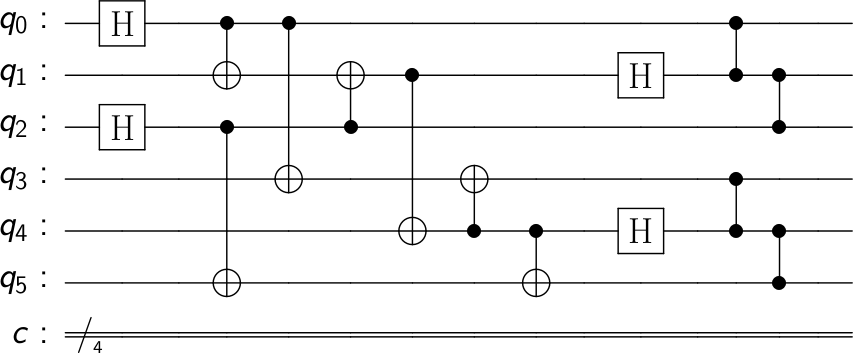

None

In [7]:
qc = cod()
display(qc.draw(output = 'latex', plot_barriers=False),
        print("Profundidad del Circuito: ", qc.depth()))


In [ ]:
Statevector&([0.25+0.j, 0.  +0.j, 0.25+0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j,\\
           &  0.  +0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j,\\
           &  0.25+0.j, 0.  +0.j, 0.25+0.j, 0.  +0.j, 0.25+0.j, 0.  +0.j,\\
           &  0.25+0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j,\\
           &  0.  +0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j, 0.25+0.j, 0.  +0.j,\\
           &  0.25+0.j, 0.  +0.j, 0.  +0.j, 0.25+0.j, 0.  +0.j, 0.25+0.j,\\
           &  0.  +0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j,\\
           &  0.  +0.j, 0.  +0.j, 0.  +0.j, 0.25+0.j, 0.  +0.j, 0.25+0.j,\\
           &  0.  +0.j, 0.25+0.j, 0.  +0.j, 0.25+0.j, 0.  +0.j, 0.  +0.j,\\
           &  0.  +0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j,\\
           &  0.  +0.j, 0.25+0.j, 0.  +0.j, 0.25+0.j],\\
           & dims=(2, 2, 2, 2, 2, 2))

Statevector([0.25+0.j, 0.  +0.j, 0.25+0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j,
             0.  +0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j,
             0.25+0.j, 0.  +0.j, 0.25+0.j, 0.  +0.j, 0.25+0.j, 0.  +0.j,
             0.25+0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j,
             0.  +0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j, 0.25+0.j, 0.  +0.j,
             0.25+0.j, 0.  +0.j, 0.  +0.j, 0.25+0.j, 0.  +0.j, 0.25+0.j,
             0.  +0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j,
             0.  +0.j, 0.  +0.j, 0.  +0.j, 0.25+0.j, 0.  +0.j, 0.25+0.j,
             0.  +0.j, 0.25+0.j, 0.  +0.j, 0.25+0.j, 0.  +0.j, 0.  +0.j,
             0.  +0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j,
             0.  +0.j, 0.25+0.j, 0.  +0.j, 0.25+0.j],
            dims=(2, 2, 2, 2, 2, 2))


None

C:\ProgramData\Anaconda3\envs\MyEnv\lib\site-packages\qiskit\visualization\state_visualization.py:705: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  xs, ys, _ = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)


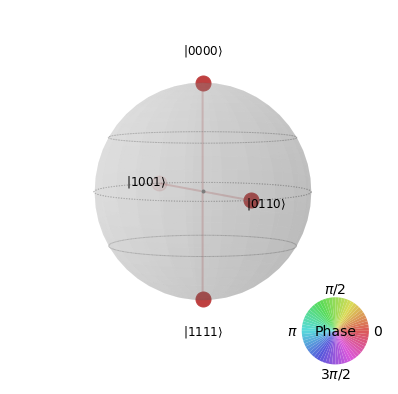

In [8]:
svs = BasicAer.get_backend('statevector_simulator')
qc_svs = execute(qc, svs).result()
qc_P  = qi.partial_trace(qi.DensityMatrix(qc_svs.get_statevector(qc)), [1, 4])
qc_sv = qi.Statevector.from_instruction(qc)
display(print(qc_sv),
        #psi.draw(output='qsphere'),
        qc_P.draw(output='qsphere'),
        # plot_state_city(Ro_psi),
        #plot_state_hinton(psi)
       )


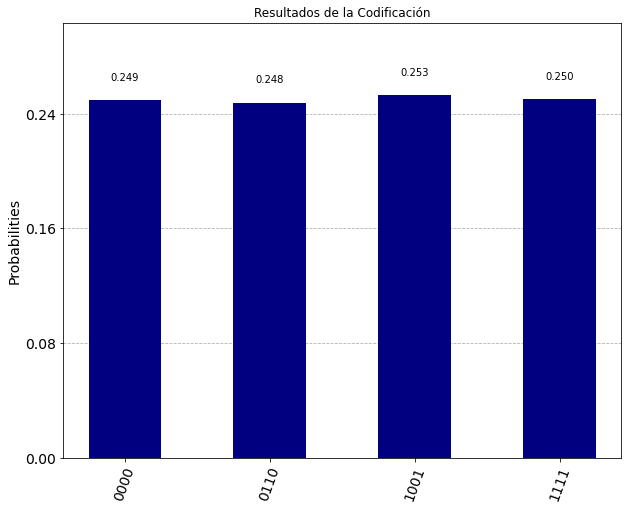

In [9]:
qc_meas = qc.copy()
qc_meas.measure([0, 2, 3, 5], [0, 1, 2, 3])
sim = Aer.get_backend('qasm_simulator')
results = execute(qc_meas, backend = sim, shots = shots).result()
counts = results.get_counts()
plth(counts,
     title='Resultados de la Codificación',
     color=[
            'navy'
           ],
     figsize=(10,8)
)

In [25]:
print(counts)
for i in counts:
    print(i, ': ',counts[i], '/',round(counts[i]/shots, 5))

{'0000': 2042, '0110': 2030, '1111': 2048, '1001': 2072}
0000 :  2042 / 0.24927
0110 :  2030 / 0.2478
1111 :  2048 / 0.25
1001 :  2072 / 0.25293


In [11]:
# Transpile the circuit for the noisy sistem's basis gates
tqc_sim_m = transpile(cod(False), qcomp_sim_M,)
tqc_sim_m_sv = qi.Statevector.from_instruction(tqc_sim_m)
tqc_sim_m_meas = transpile(qc_meas, qcomp_sim_M)

tqc_sim_t = transpile(cod(False), qcomp_sim_T)
tqc_sim_t_sv = qi.Statevector.from_instruction(tqc_sim_t)
tqc_sim_t_meas = transpile(qc_meas, qcomp_sim_T)

tqc_sim_s = transpile(cod(False), qcomp_sim_S)
tqc_sim_s_sv = qi.Statevector.from_instruction(tqc_sim_s)
tqc_sim_s_meas = transpile(qc_meas, qcomp_sim_S)




Profundidad del Circuito usando el modelo de prueba:
  49


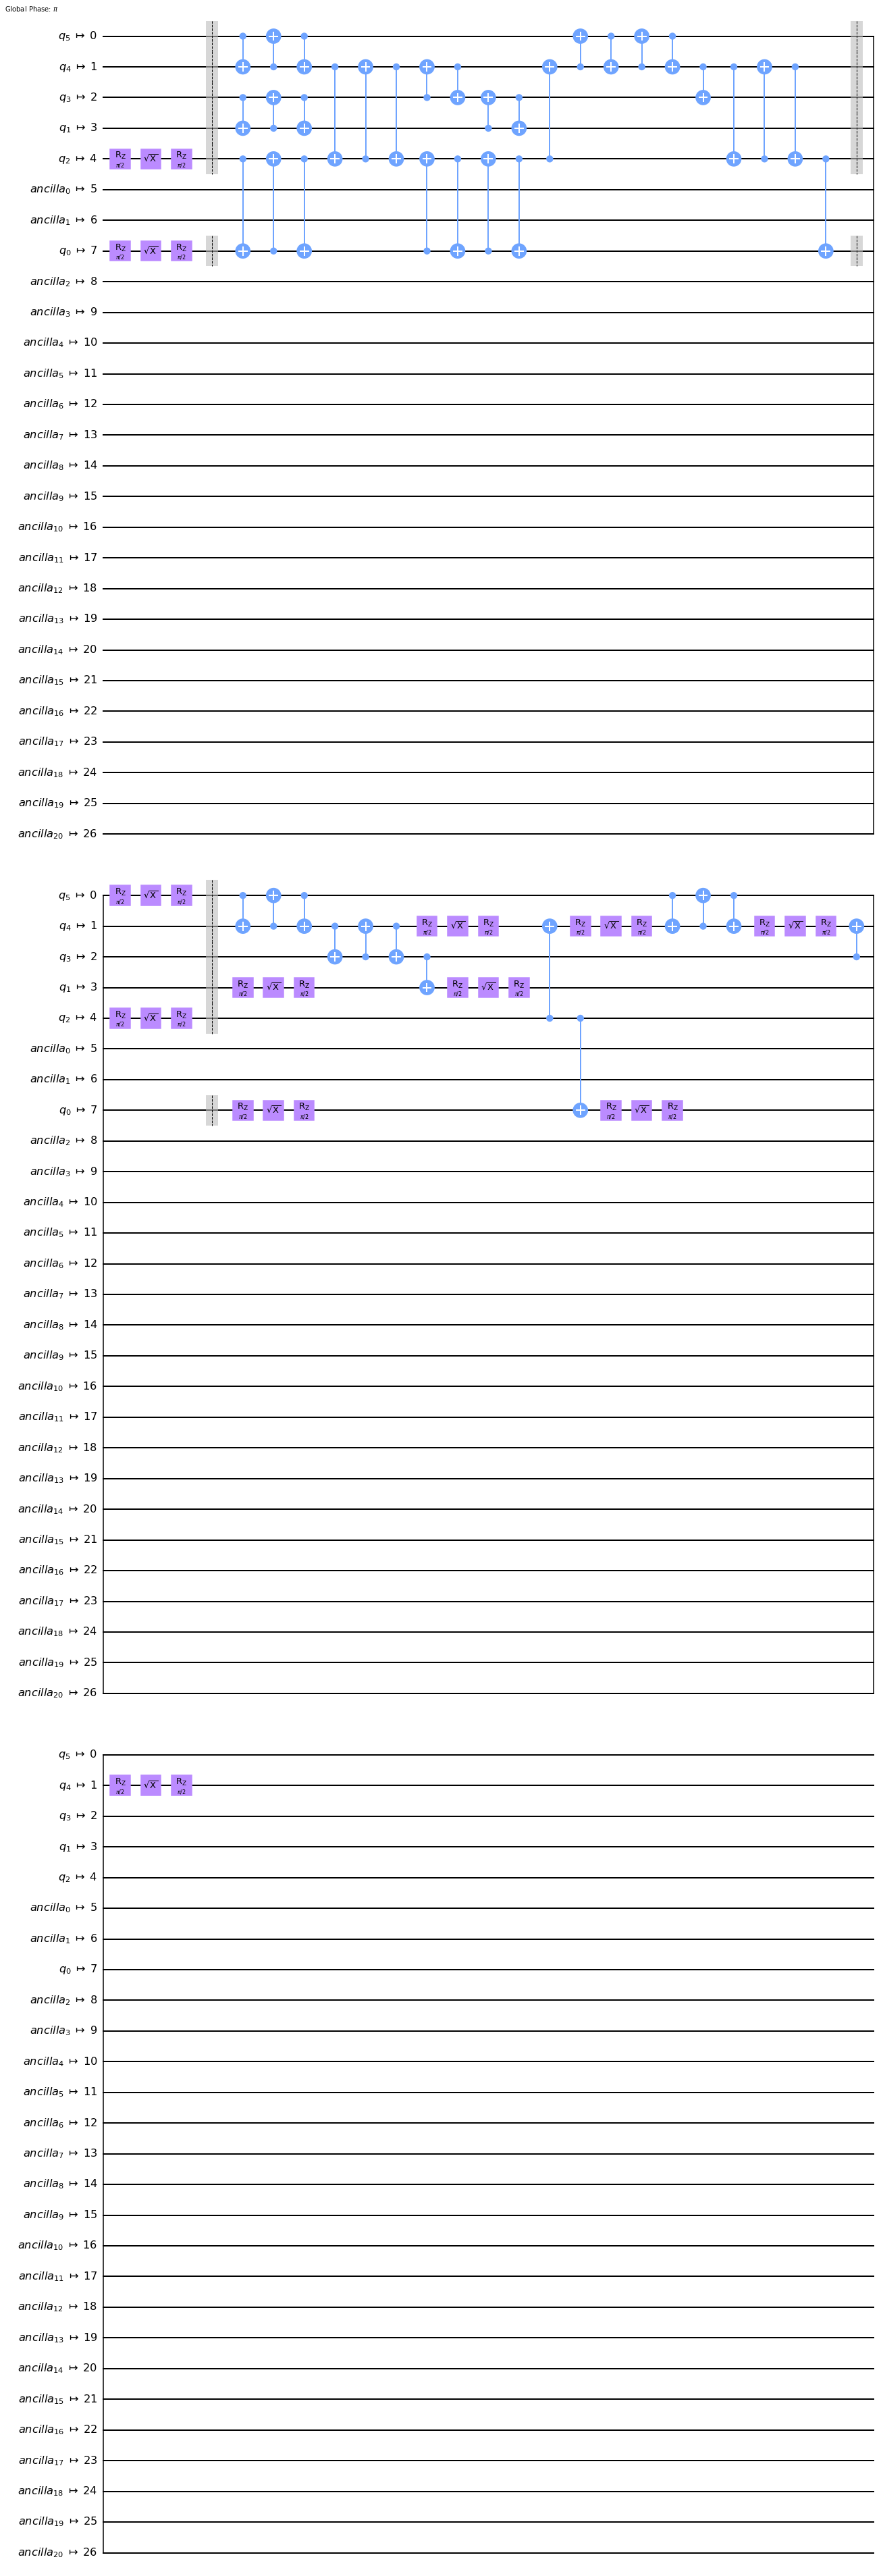

None

In [12]:
mpl.rcParams["figure.figsize"] = mpl.rcParamsDefault["figure.figsize"]

display(tqc_sim_m.draw('mpl'),
#        print("\n\nVector de estado del Circuito usando el modelo de prueba:\n ", tqc_sim_m_sv),
        print("\n\nProfundidad del Circuito usando el modelo de prueba:\n ", tqc_sim_m.depth()))




Profundidad del Circuito usando el modelo de prueba:
  46


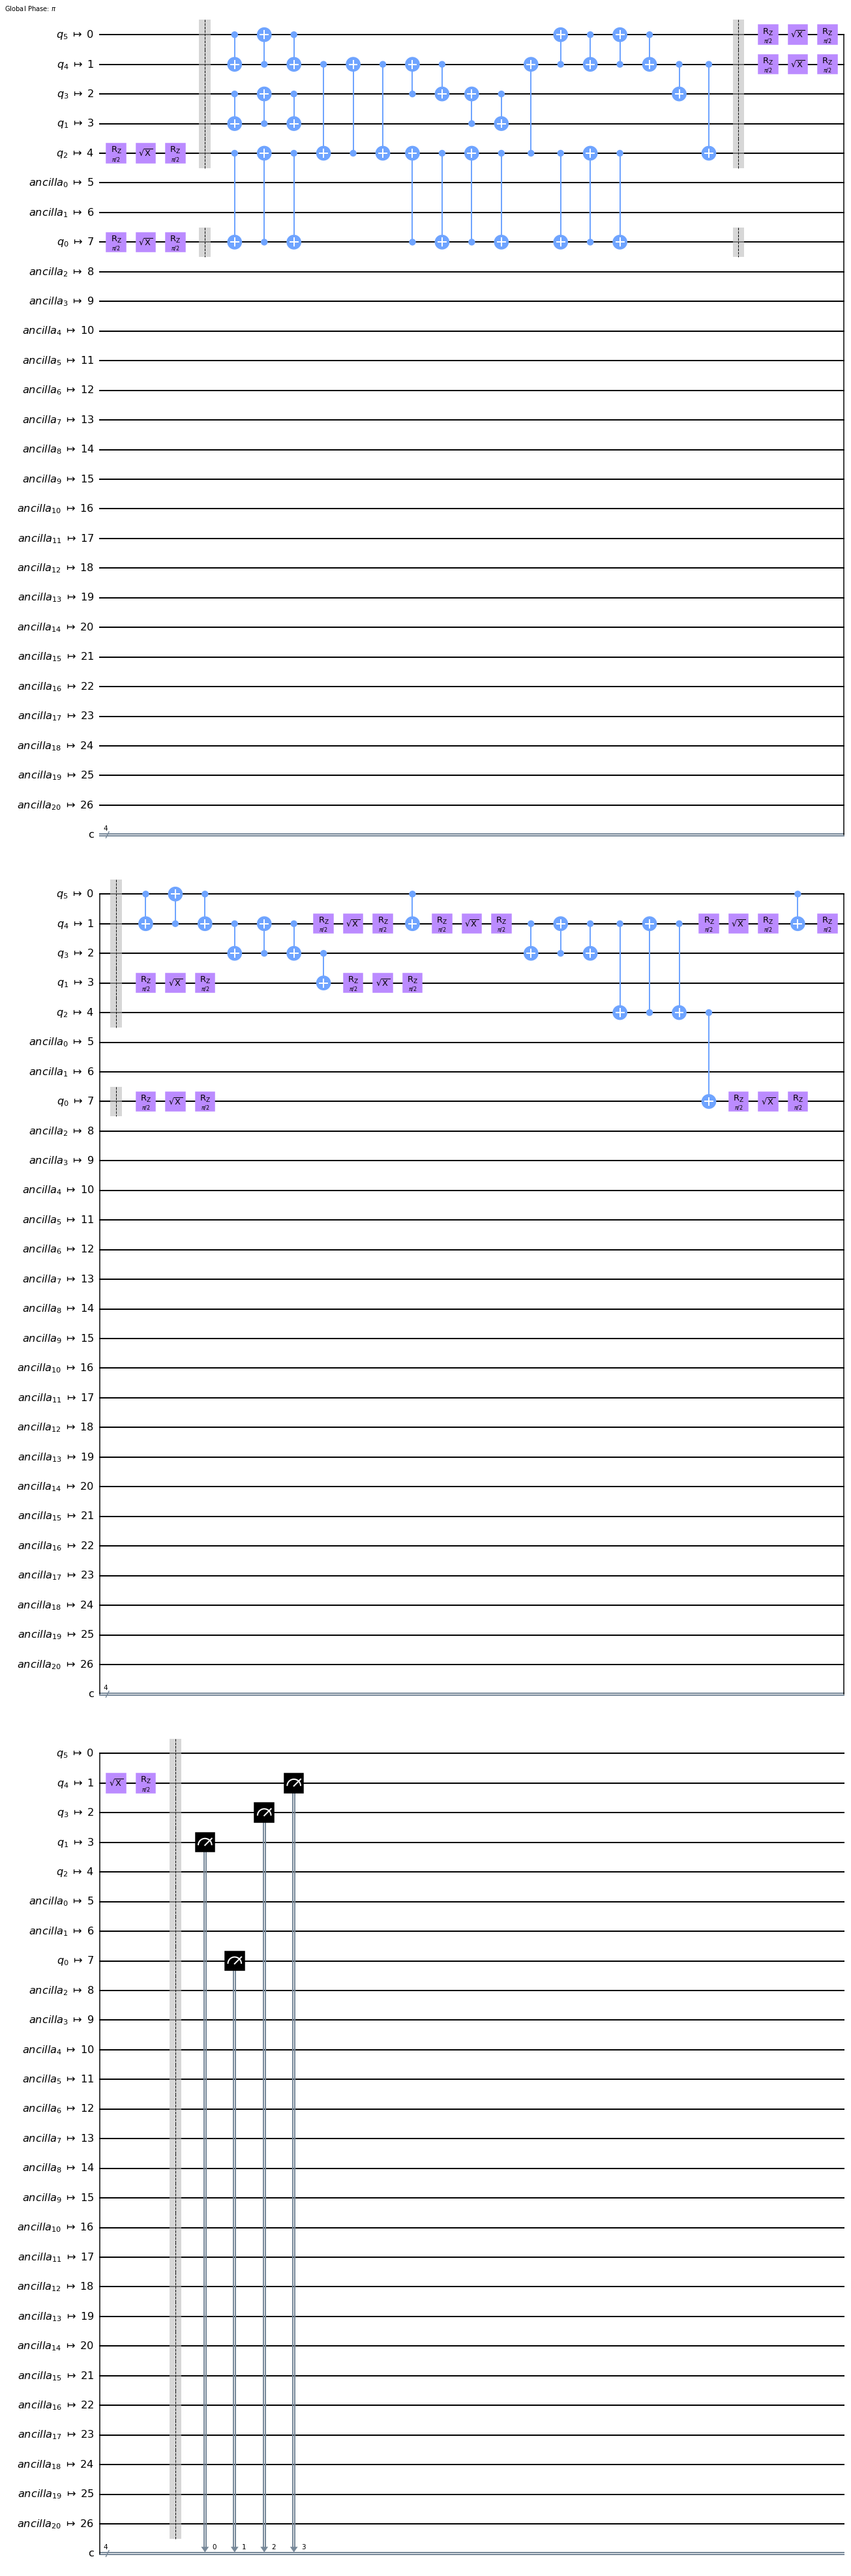

None

In [13]:
mpl.rcParams["figure.figsize"] = mpl.rcParamsDefault["figure.figsize"]

display(tqc_sim_t_meas.draw('mpl'),
#        print("\n\nVector de estado del Circuito usando el modelo de prueba:\n ", tqc_sim_t_sv),
        print("\n\nProfundidad del Circuito usando el modelo de prueba:\n ", tqc_sim_t.depth()))




Profundidad del Circuito usando el modelo de prueba:
  49


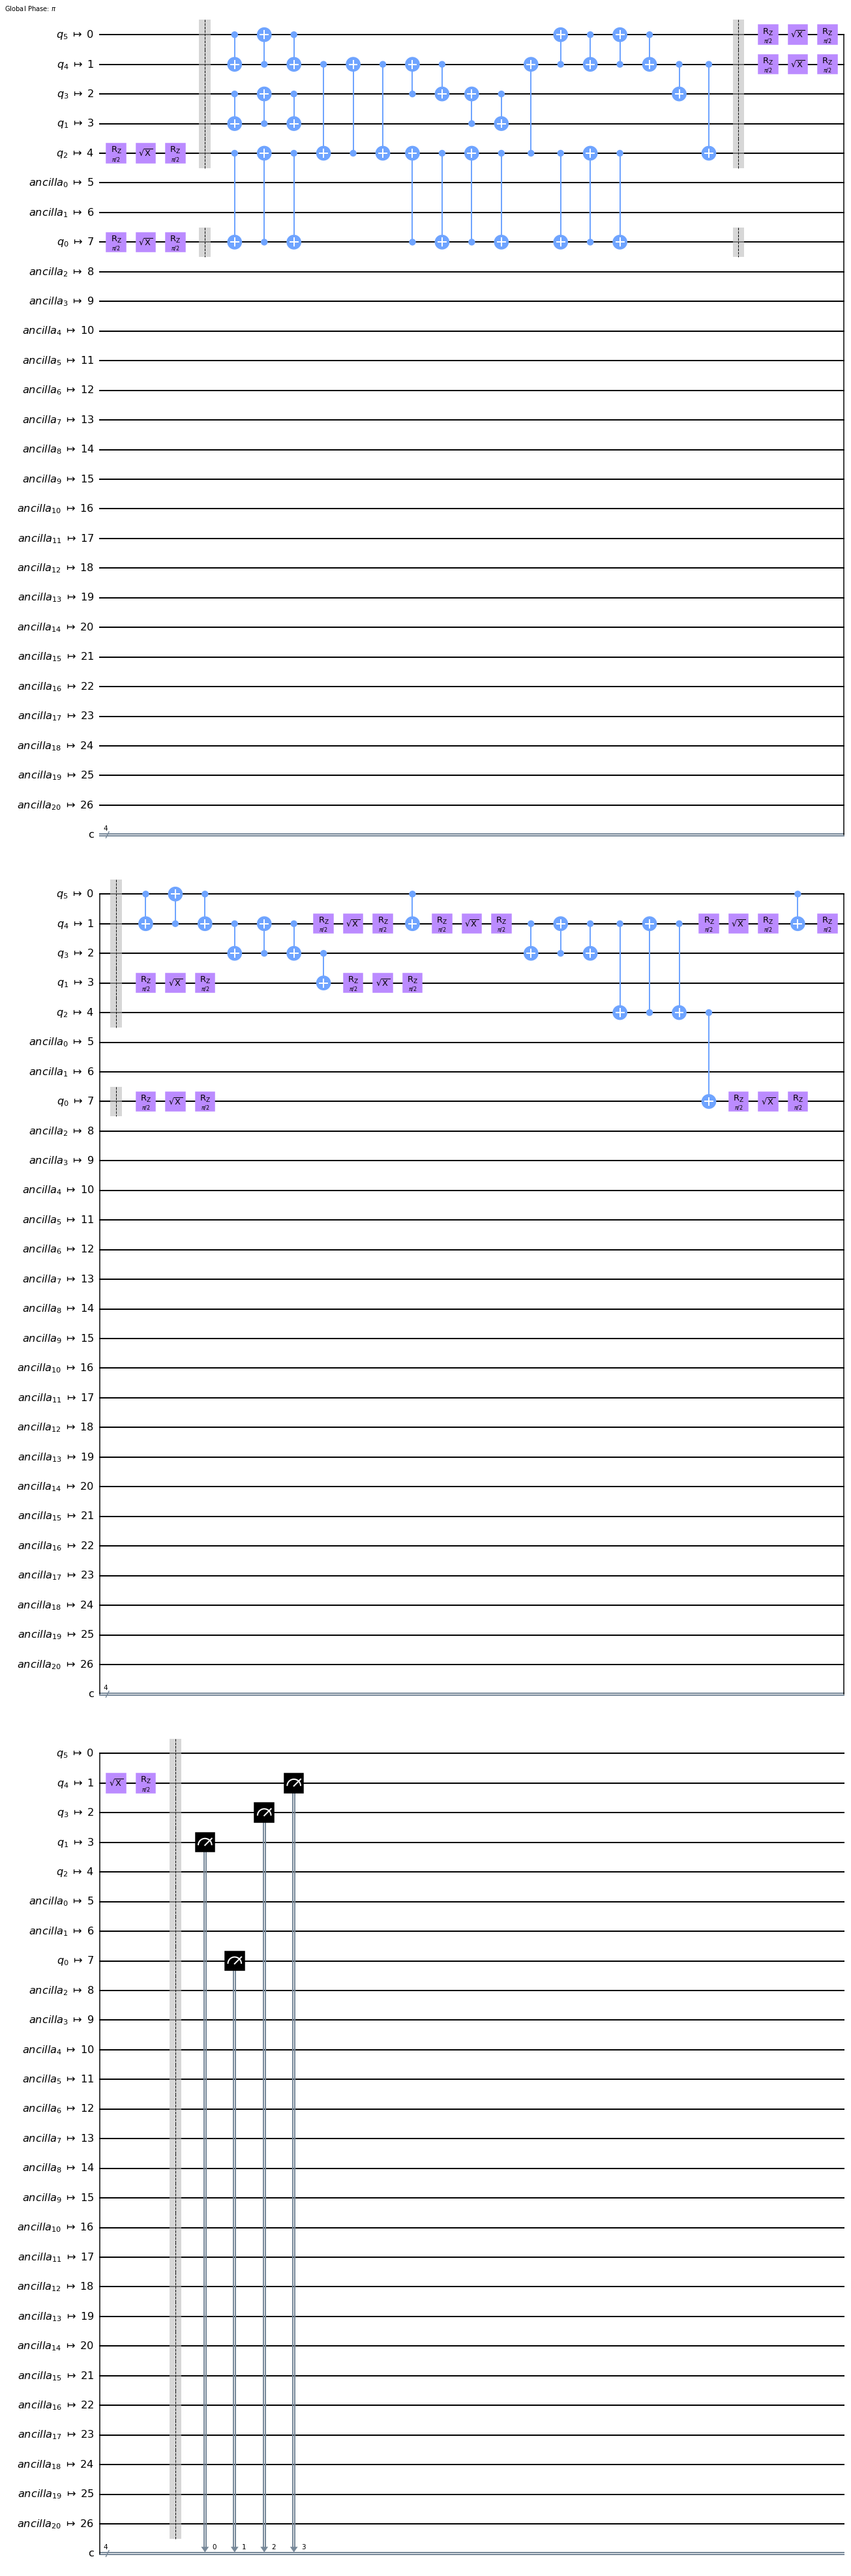

None

In [14]:
mpl.rcParams["figure.figsize"] = mpl.rcParamsDefault["figure.figsize"]

display(tqc_sim_s_meas.draw('mpl'),
#        print("\n\nVector de estado del Circuito usando el modelo de prueba:\n ", tqc_sim_s_sv),
        print("\n\nProfundidad del Circuito usando el modelo de prueba:\n ", tqc_sim_s.depth()))


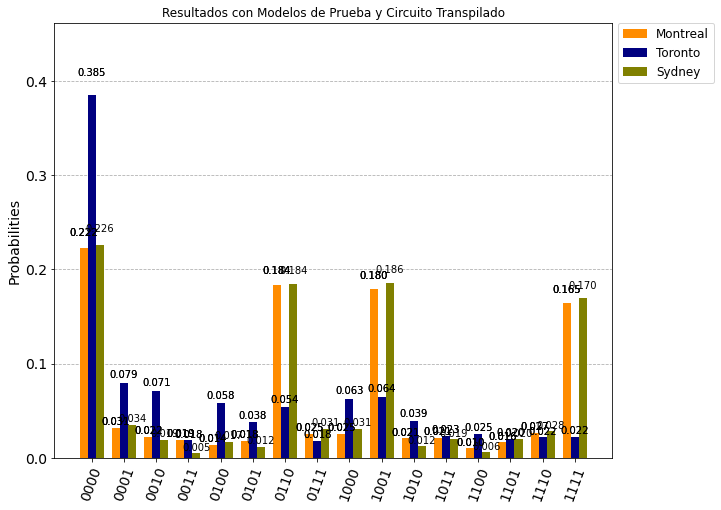

In [12]:
# Execute noisy simulation on dummys and get counts
result_noise_sim_m = qcomp_sim_M.run(tqc_sim_m_meas, shots=shots).result()
result_noise_sim_t = qcomp_sim_T.run(tqc_sim_t_meas, shots=shots).result()
result_noise_sim_s = qcomp_sim_S.run(tqc_sim_s_meas, shots=shots).result()

counts_noise_sim_m = result_noise_sim_m.get_counts(tqc_sim_m_meas)
counts_noise_sim_t = result_noise_sim_t.get_counts(tqc_sim_t_meas)
counts_noise_sim_s = result_noise_sim_s.get_counts(tqc_sim_s_meas)

plth(
    [counts_noise_sim_m,
     counts_noise_sim_t,
     counts_noise_sim_s
    ],
    legend=['Montreal',
            'Toronto',
            'Sydney'
           ],
    title='Resultados con Modelos de Prueba y Circuito Transpilado',
    color=['darkorange',
           'navy',
           'olive'
          ],
    figsize=(10, 8)
)

In [19]:
print('Cuentas de la codificación con "Montreal": \n', counts_noise_sim_m)
for i in counts_noise_sim_m:
    print(i, ': ',counts_noise_sim_m[i], '/',counts_noise_sim_m[i]/shots)
print('\nCuentas de la codificación con "Toronto": \n', counts_noise_sim_t)
for i in counts_noise_sim_t:
    print(i, ': ',counts_noise_sim_t[i], '/',counts_noise_sim_t[i]/shots)
print('\nCuentas de la codificación con "Sydney": \n', counts_noise_sim_s)
for i in counts_noise_sim_s:
    print(i, ': ',counts_noise_sim_s[i], '/',counts_noise_sim_s[i]/shots)


Cuentas de la codificación con "Montreal": 
 {'1111': 1349, '0110': 1506, '1110': 218, '0101': 148, '0111': 204, '1001': 1471, '0000': 1822, '0100': 114, '0001': 256, '0010': 181, '1011': 172, '1100': 85, '1010': 168, '1000': 206, '1101': 135, '0011': 157}
1111 :  1349 / 0.1646728515625
0110 :  1506 / 0.183837890625
1110 :  218 / 0.026611328125
0101 :  148 / 0.01806640625
0111 :  204 / 0.02490234375
1001 :  1471 / 0.1795654296875
0000 :  1822 / 0.222412109375
0100 :  114 / 0.013916015625
0001 :  256 / 0.03125
0010 :  181 / 0.0220947265625
1011 :  172 / 0.02099609375
1100 :  85 / 0.0103759765625
1010 :  168 / 0.0205078125
1000 :  206 / 0.025146484375
1101 :  135 / 0.0164794921875
0011 :  157 / 0.0191650390625

Cuentas de la codificación con "Toronto": 
 {'1001': 527, '0001': 650, '1111': 184, '0110': 444, '1000': 514, '0000': 3154, '0100': 473, '0101': 308, '1010': 321, '0010': 582, '1011': 191, '0011': 151, '1100': 204, '1110': 177, '0111': 149, '1101': 163}
1001 :  527 / 0.06433105468

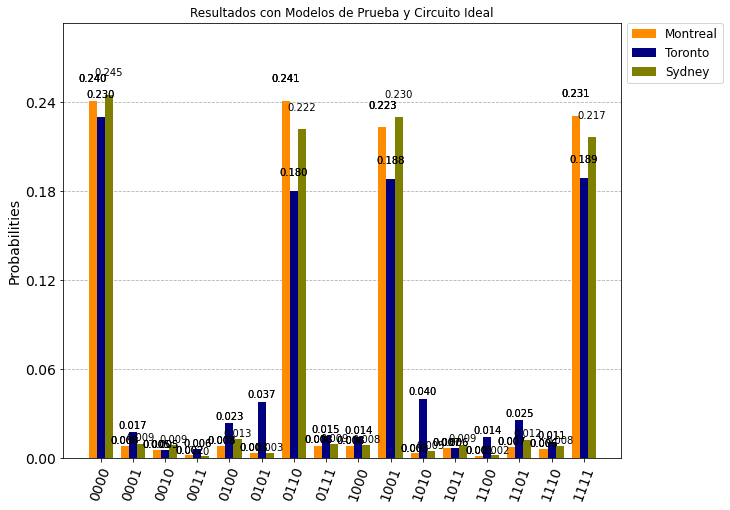

In [14]:
# Execute noisy simulation on dummys and get counts
result_noise_m = qcomp_sim_M.run(qc_meas, shots=shots).result()
result_noise_t = qcomp_sim_T.run(qc_meas, shots=shots).result()
result_noise_s = qcomp_sim_S.run(qc_meas, shots=shots).result()

counts_noise_m = result_noise_m.get_counts(qc_meas)
counts_noise_t = result_noise_t.get_counts(qc_meas)
counts_noise_s = result_noise_s.get_counts(qc_meas)

plth(
    [counts_noise_m,
     counts_noise_t,
     counts_noise_s
    ],
    legend=['Montreal',
            'Toronto',
            'Sydney'
           ],
    title='Resultados con Modelos de Prueba y Circuito Ideal',
    color=['darkorange',
           'navy',
           'olive'
          ],
    figsize=(10, 8)
)

In [24]:
for i in range(len(counts_noise_m)):
    print('{0:04b}'.format(i), ' ',counts_noise_m['{0:04b}'.format(i)], '/',
          round(counts_noise_m['{0:04b}'.format(i)]/shots, 5), ' ',
          counts_noise_t['{0:04b}'.format(i)], '/',
          round(counts_noise_t['{0:04b}'.format(i)]/shots, 5), ' ',
          counts_noise_s['{0:04b}'.format(i)], '/',
          round(counts_noise_s['{0:04b}'.format(i)]/shots, 5), ' '
         )

0000   1970 / 0.24048   1885 / 0.2301   2003 / 0.24451  
0001   63 / 0.00769   141 / 0.01721   77 / 0.0094  
0010   45 / 0.00549   42 / 0.00513   71 / 0.00867  
0011   13 / 0.00159   48 / 0.00586   8 / 0.00098  
0100   65 / 0.00793   190 / 0.02319   103 / 0.01257  
0101   28 / 0.00342   305 / 0.03723   27 / 0.0033  
0110   1971 / 0.2406   1474 / 0.17993   1818 / 0.22192  
0111   67 / 0.00818   120 / 0.01465   74 / 0.00903  
1000   62 / 0.00757   115 / 0.01404   68 / 0.0083  
1001   1826 / 0.2229   1540 / 0.18799   1884 / 0.22998  
1010   24 / 0.00293   324 / 0.03955   37 / 0.00452  
1011   55 / 0.00671   53 / 0.00647   72 / 0.00879  
1100   9 / 0.0011   114 / 0.01392   13 / 0.00159  
1101   57 / 0.00696   208 / 0.02539   99 / 0.01208  
1110   47 / 0.00574   88 / 0.01074   64 / 0.00781  
1111   1890 / 0.23071   1545 / 0.1886   1774 / 0.21655  


In [20]:
print('Cuentas de la codificación simulada con "Montreal": \n', counts_noise_m)
for i in counts_noise_m:
    print(i, ': ',counts_noise_m[i], '/',counts_noise_m[i]/shots)
print('\nCuentas de la codificación simulada con "Toronto": \n', counts_noise_t)
for i in counts_noise_t:
    print(i, ': ',counts_noise_t[i], '/',counts_noise_t[i]/shots)
print('\nCuentas de la codificación simulada con "Sydney": \n', counts_noise_s)
for i in counts_noise_s:
    print(i, ': ',counts_noise_s[i], '/',counts_noise_s[i]/shots)


Cuentas de la codificación simulada con "Montreal": 
 {'0000': 1970, '0110': 1971, '1111': 1890, '1001': 1826, '0111': 67, '0010': 45, '0101': 28, '1101': 57, '0001': 63, '1011': 55, '1110': 47, '1000': 62, '0100': 65, '1010': 24, '0011': 13, '1100': 9}
0000 :  1970 / 0.240478515625
0110 :  1971 / 0.2406005859375
1111 :  1890 / 0.230712890625
1001 :  1826 / 0.222900390625
0111 :  67 / 0.0081787109375
0010 :  45 / 0.0054931640625
0101 :  28 / 0.00341796875
1101 :  57 / 0.0069580078125
0001 :  63 / 0.0076904296875
1011 :  55 / 0.0067138671875
1110 :  47 / 0.0057373046875
1000 :  62 / 0.007568359375
0100 :  65 / 0.0079345703125
1010 :  24 / 0.0029296875
0011 :  13 / 0.0015869140625
1100 :  9 / 0.0010986328125

Cuentas de la codificación simulada con "Toronto": 
 {'1010': 324, '0001': 141, '1001': 1540, '1000': 115, '0000': 1885, '1111': 1545, '0110': 1474, '0101': 305, '1101': 208, '0100': 190, '0111': 120, '1100': 114, '1110': 88, '0011': 48, '0010': 42, '1011': 53}
1010 :  324 / 0.03955

In [17]:
t = time.time()

P_sim = tomo(qc=cod(False),
             backend=qcomp_sim_M,
             qubits=[0, 1, 2, 3, 4, 5],
             trans=False
            ) 

F_sim_m = qi.state_fidelity(P_sim[0], qc_sv)
F_sim_m_mit = qi.state_fidelity(P_sim[2], qc_sv)
print('Fidelidad en el Modelo de prueba de "Belem" (s/ corrección): F = {:.5f}'.format(F_sim_m))
print('                                            (c/ corrección): F = {:.5f}'.format(F_sim_m_mit))
print('\n\nTiempo de ejecución [minutos] (s/ corrección): t = {:.5f}'.format(P_sim[1]))
print('                              (c/ corrección): t = {:.5f}'.format(P_sim[3]))
print('\n\nTiempo transcurrido [segundos] : t = {:.5f}'.format(time.time() - t))


C:\ProgramData\Anaconda3\envs\MyEnv\lib\site-packages\qiskit\ignis\verification\tomography\basis\circuits.py:468: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  prep += circuit
C:\ProgramData\Anaconda3\envs\MyEnv\lib\site-packages\qiskit\circuit\quantumcircuit.py:876: DeprecationWarning: The QuantumCircuit.extend() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  return self.extend(rhs)
C:\ProgramData\Anaconda3\envs\MyEnv\lib\site-packages\qiskit\ignis\verification\tomography\basis\circuits.py:478: DeprecationWarning: The QuantumCircuit.__add__() method is being deprecated.Use the compose() method which is more flexible w.r.t circuit register compatibility.
  circ = prep + meas
C:\Prog

Fidelidad en el Modelo de prueba de "Belem" (s/ corrección): F = 0.57741
                                            (c/ corrección): F = 0.66565


Tiempo de ejecución [minutos] (s/ corrección): t = 3.02316
                              (c/ corrección): t = 3.46857


Tiempo transcurrido [segundos] : t = 668.70254


In [18]:
t = time.time()

P_sim = tomo(qc=cod(False),
             backend=qcomp_sim_T,
             qubits=[0, 1, 2, 3, 4, 5],
             trans=False
            ) 

F_sim_t = qi.state_fidelity(P_sim[0], qc_sv)
F_sim_t_mit = qi.state_fidelity(P_sim[2], qc_sv)
print('Fidelidad en el Modelo de prueba de "Quito" (s/ corrección): F = {:.5f}'.format(F_sim_t))
print('                                            (c/ corrección): F = {:.5f}'.format(F_sim_t_mit))
print('\n\nTiempo de ejecución [minutos] (s/ corrección): t = {:.5f}'.format(P_sim[1]))
print('                              (c/ corrección): t = {:.5f}'.format(P_sim[3]))
print('\n\nTiempo transcurrido [segundos] : t = {:.5f}'.format(time.time() - t))


Fidelidad en el Modelo de prueba de "Quito" (s/ corrección): F = 0.10372
                                            (c/ corrección): F = 0.11756


Tiempo de ejecución [minutos] (s/ corrección): t = 1.06930
                              (c/ corrección): t = 1.22554


Tiempo transcurrido [segundos] : t = 516.57090


In [19]:
t = time.time()

P_sim = tomo(qc=cod(False),
             backend=qcomp_sim_S,
             qubits=[0, 1, 2, 3, 4, 5],
             trans=False
            ) 

F_sim_s = qi.state_fidelity(P_sim[0], qc_sv)
F_sim_s_mit = qi.state_fidelity(P_sim[2], qc_sv)
print('Fidelidad en el Modelo de prueba de "Lima" (s/ corrección): F = {:.5f}'.format(F_sim_s))
print('                                           (c/ corrección): F = {:.5f}'.format(F_sim_s_mit))
print('\n\nTiempo de ejecución [minutos] (s/ corrección): t = {:.5f}'.format(P_sim[1]))
print('                              (c/ corrección): t = {:.5f}'.format(P_sim[3]))
print('\n\nTiempo transcurrido [segundos] : t = {:.5f}'.format(time.time() - t))


Fidelidad en el Modelo de prueba de "Lima" (s/ corrección): F = 0.50768
                                           (c/ corrección): F = 0.59790


Tiempo de ejecución [minutos] (s/ corrección): t = 3.14209
                              (c/ corrección): t = 3.51265


Tiempo transcurrido [segundos] : t = 631.38890


In [16]:
# RUIDOS

noisy_amp = amp_noise(p=p_amp)

noisy_phs = phs_noise(p=p_phs)

noisy_dprz = dprz_noise(p=p_dprz)

print(noisy_amp)
print(noisy_phs)
print(noisy_dprz)


NoiseModel:
  Basis gates: ['cx', 'cz', 'id', 'rz', 'sx', 'u3', 'x']
  Instructions with noise: ['cx', 'cz', 'rz', 'x', 'u3', 'sx']
  All-qubits errors: ['rz', 'sx', 'x', 'u3', 'cx', 'cz']
NoiseModel:
  Basis gates: ['cx', 'cz', 'id', 'rz', 'sx', 'u3', 'x']
  Instructions with noise: ['cx', 'cz', 'rz', 'x', 'u3', 'sx']
  All-qubits errors: ['rz', 'sx', 'x', 'u3', 'cx', 'cz']
NoiseModel:
  Basis gates: ['cx', 'cz', 'id', 'rz', 'sx', 'u3', 'x']
  Instructions with noise: ['cx', 'cz', 'rz', 'x', 'u3', 'sx']
  All-qubits errors: ['rz', 'sx', 'x', 'u3', 'cx', 'cz']


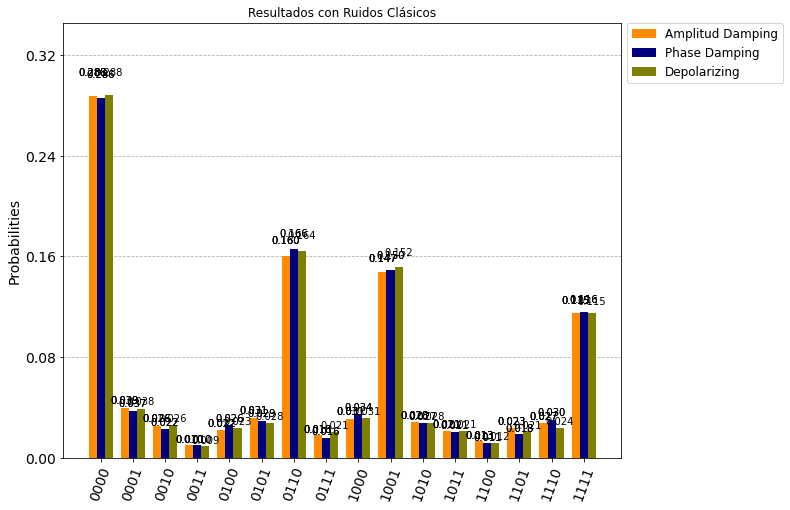

In [17]:
# Simular el Ruido de Amplitud Damping
sim_noise_amp = AerSimulator(noise_model=noisy_amp)
sim_noise_phs = AerSimulator(noise_model=noisy_phs)
sim_noise_dprz = AerSimulator(noise_model=noisy_dprz)

tqc_noise_amp = transpile(qc, sim_noise_amp)
tqc_noise_phs = transpile(qc, sim_noise_phs)
tqc_noise_dprz = transpile(qc, sim_noise_dprz)

tqc_noise_amp_meas = tqc_noise_amp.copy()
tqc_noise_amp_meas.measure([0, 2, 3, 5], [0, 1, 2, 3])
result_noise_amp = sim_noise_amp.run(tqc_noise_amp_meas, shots=shots).result()

tqc_noise_phs_meas = tqc_noise_phs.copy()
tqc_noise_phs_meas.measure([0, 2, 3, 5], [0, 1, 2, 3])
result_noise_phs = sim_noise_amp.run(tqc_noise_phs_meas, shots=shots).result()

tqc_noise_dprz_meas = tqc_noise_dprz.copy()
tqc_noise_dprz_meas.measure([0, 2, 3, 5], [0, 1, 2, 3])
result_noise_dprz = sim_noise_amp.run(tqc_noise_dprz_meas, shots=shots).result()

counts_noise_amp = result_noise_amp.get_counts(tqc_noise_amp_meas)
counts_noise_phs = result_noise_phs.get_counts(tqc_noise_phs_meas)
counts_noise_dprz = result_noise_dprz.get_counts(tqc_noise_dprz_meas)

plth(
    [counts_noise_amp,
     counts_noise_phs,
     counts_noise_dprz
    ],
    legend=['Amplitud Damping',
            'Phase Damping',
            'Depolarizing'
           ],
    title='Resultados con Ruidos Clásicos',
    color=['darkorange',
           'navy',
           'olive'
          ],
    figsize=(10, 8)
)

In [23]:
print('Cuentas de la codificación con Amp Dmp: \n', counts_noise_amp)
for i in counts_noise_amp:
    print(i, ': ',counts_noise_amp[i], '/',counts_noise_amp[i]/shots)
print('\nCuentas de la codificación con Phs Dmp: \n', counts_noise_phs)
for i in counts_noise_phs:
    print(i, ': ',counts_noise_phs[i], '/',counts_noise_phs[i]/shots)
print('\nCuentas de la codificación con Dprz: \n', counts_noise_dprz)
for i in counts_noise_dprz:
    print(i, ': ',counts_noise_dprz[i], '/',counts_noise_dprz[i]/shots)


Cuentas de la codificación con Amp Dmp: 
 {'1000': 253, '0000': 2358, '0010': 209, '1001': 1206, '1111': 941, '0110': 1314, '0011': 82, '1101': 190, '0111': 146, '1010': 230, '0101': 258, '1011': 172, '0100': 180, '1110': 223, '0001': 322, '1100': 108}
1000 :  253 / 0.0308837890625
0000 :  2358 / 0.287841796875
0010 :  209 / 0.0255126953125
1001 :  1206 / 0.147216796875
1111 :  941 / 0.1148681640625
0110 :  1314 / 0.160400390625
0011 :  82 / 0.010009765625
1101 :  190 / 0.023193359375
0111 :  146 / 0.017822265625
1010 :  230 / 0.028076171875
0101 :  258 / 0.031494140625
1011 :  172 / 0.02099609375
0100 :  180 / 0.02197265625
1110 :  223 / 0.0272216796875
0001 :  322 / 0.039306640625
1100 :  108 / 0.01318359375

Cuentas de la codificación con Phs Dmp: 
 {'0000': 2342, '1000': 282, '0110': 1357, '1111': 951, '0101': 241, '1001': 1225, '1010': 225, '1011': 168, '0001': 307, '0111': 130, '1110': 246, '0011': 80, '0010': 184, '1101': 151, '1100': 93, '0100': 210}
0000 :  2342 / 0.2858886718

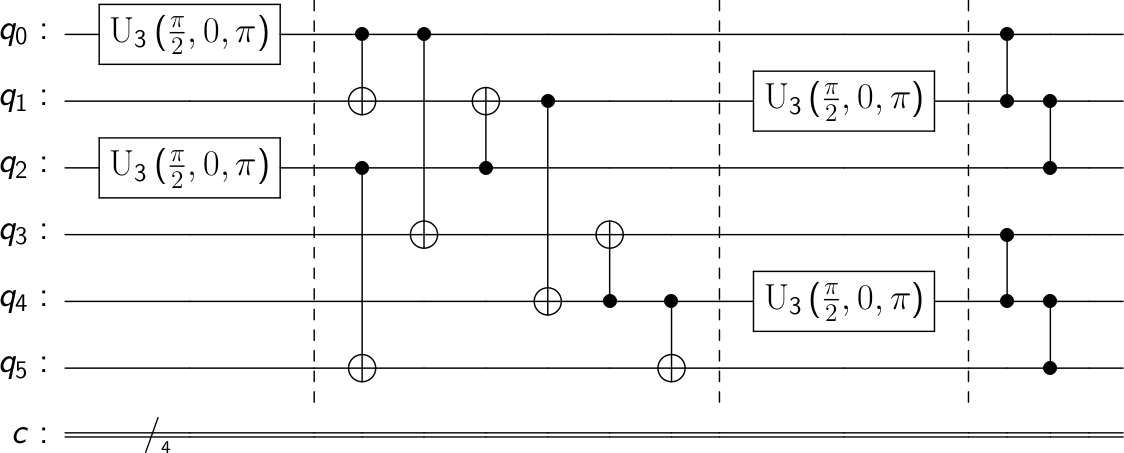

In [21]:
mpl.rcParams["figure.figsize"] = mpl.rcParamsDefault["figure.figsize"]
tqc_noise_amp.draw('latex')

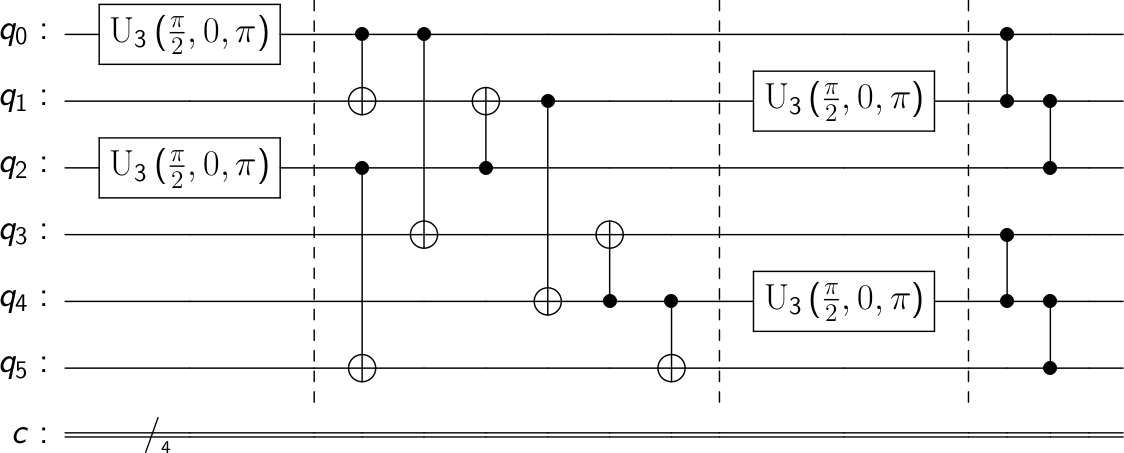

In [22]:
mpl.rcParams["figure.figsize"] = mpl.rcParamsDefault["figure.figsize"]
tqc_noise_phs.draw('latex')

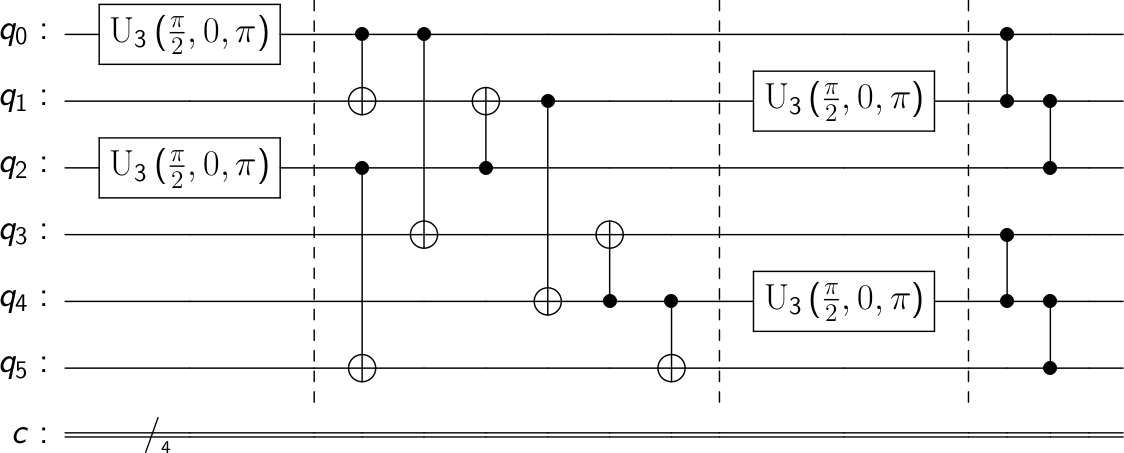

In [23]:
mpl.rcParams["figure.figsize"] = mpl.rcParamsDefault["figure.figsize"]
tqc_noise_dprz.draw('latex')

In [23]:
t = time.time()

P_amp = tomo(qc=cod(False),
             backend=sim_noise_amp,
             qubits=[0, 1, 2, 3, 4, 5],
            ) 

F_amp = qi.state_fidelity(P_amp[0], qc_sv)
F_amp_mit = qi.state_fidelity(P_amp[2], qc_sv)
print('Fidelidad en el Modelo de Ruido "Amplitud Damping" (s/ corrección): F = {:.5f}'.format(F_amp))
print('                                                   (c/ corrección): F = {:.5f}'.format(F_amp_mit))
print('\n\nTiempo de ejecución [minutos] (s/ corrección): t = {:.5f}'.format(P_amp[1]))
print('                              (c/ corrección): t = {:.5f}'.format(P_amp[3]))
print('\n\nTiempo transcurrido [segundos] : t = {:.5f}'.format(time.time() - t))


Fidelidad en el Modelo de Ruido "Amplitud Damping" (s/ corrección): F = 0.51177
                                                   (c/ corrección): F = 0.58764


Tiempo de ejecución [minutos] (s/ corrección): t = 0.93392
                              (c/ corrección): t = 1.03488


Tiempo transcurrido [segundos] : t = 792.48125


In [24]:
t = time.time()

P_phs = tomo(qc=cod(False),
             backend=sim_noise_phs,
             qubits=[0, 1, 2, 3, 4, 5],
            ) 

F_phs = qi.state_fidelity(P_phs[0], qc_sv)
F_phs_mit = qi.state_fidelity(P_phs[2], qc_sv)
print('Fidelidad en el Modelo de Ruido "Phase Damping" (s/ corrección): F = {:.5f}'.format(F_phs))
print('                                                (c/ corrección): F = {:.5f}'.format(F_phs_mit))
print('\n\nTiempo de ejecución [minutos] (s/ corrección): t = {:.5f}'.format(P_phs[1]))
print('                              (c/ corrección): t = {:.5f}'.format(P_phs[3]))
print('\n\nTiempo transcurrido [segundos] : t = {:.5f}'.format(time.time() - t))


Fidelidad en el Modelo de Ruido "Phase Damping" (s/ corrección): F = 0.72646
                                                (c/ corrección): F = 0.72646


Tiempo de ejecución [minutos] (s/ corrección): t = 1.03352
                              (c/ corrección): t = 1.35175


Tiempo transcurrido [segundos] : t = 1711.29276


In [25]:
t = time.time()

P_dprz = tomo(qc=cod(False),
             backend=sim_noise_dprz,
             qubits=[0, 1, 2, 3, 4, 5],
            ) 

F_dprz = qi.state_fidelity(P_dprz[0], qc_sv)
F_dprz_mit = qi.state_fidelity(P_dprz[2], qc_sv)
print('Fidelidad en el Modelo de Ruido "Depolarizing" (s/ corrección): F = {:.5f}'.format(F_dprz))
print('                                               (c/ corrección): F = {:.5f}'.format(F_dprz))
print('\n\nTiempo de ejecución [minutos] (s/ corrección): t = {:.5f}'.format(P_dprz[1]))
print('                              (c/ corrección): t = {:.5f}'.format(P_dprz[3]))
print('\n\nTiempo transcurrido [segundos] : t = {:.5f}'.format(time.time() - t))


Fidelidad en el Modelo de Ruido "Depolarizing" (s/ corrección): F = 0.47173
                                               (c/ corrección): F = 0.47173


Tiempo de ejecución [minutos] (s/ corrección): t = 1.17333
                              (c/ corrección): t = 1.45511


Tiempo transcurrido [segundos] : t = 806.70089


In [28]:
f_amp = fid(qc, tqc_noise_amp, noisy_amp, shots)
f_phs = fid(qc, tqc_noise_phs, noisy_phs, shots)
f_dprz = fid(qc, tqc_noise_dprz, noisy_dprz, shots)

print(f_amp)
print(f_phs)
print(f_dprz)

0.5614247705600182
0.7326660156250001
0.5449218750000001


In [20]:
f_amp_sweep = []
f_phs_sweep = []
f_dprz_sweep = []
p_i = []
n = 1600

for i in range(0, n):
    p_i.append(i/n)
    print(i)
    noisy_amp_sweep = amp_noise(p=i/n)
    noisy_phs_sweep = phs_noise(p=i/n)
    noisy_dprz_sweep = dprz_noise(p=i/n)
    
    tqc_noise_amp_sweep = transpile(qc, AerSimulator(noise_model=noisy_amp))
    tqc_noise_phs_sweep = transpile(qc, AerSimulator(noise_model=noisy_phs))
    tqc_noise_dprz_sweep = transpile(qc, AerSimulator(noise_model=noisy_dprz))

    f_amp_sweep.append(fid(qc, tqc_noise_amp_sweep, noisy_amp_sweep, shots))
    f_phs_sweep.append(fid(qc, tqc_noise_phs_sweep, noisy_phs_sweep, shots))
    f_dprz_sweep.append(fid(qc, tqc_noise_dprz_sweep, noisy_dprz_sweep, shots))
    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

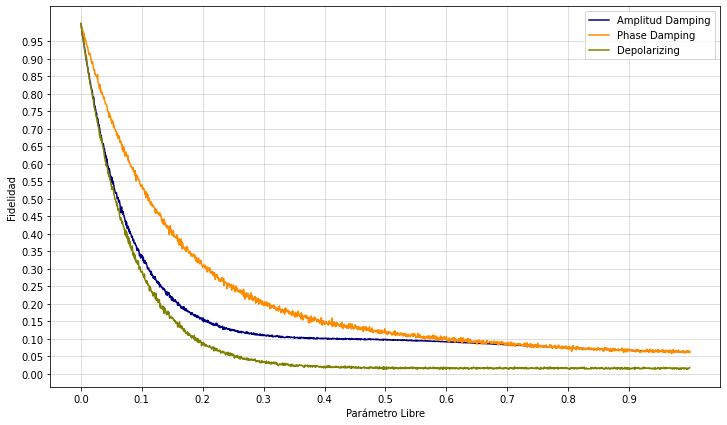

In [21]:
mpl.rcParams["figure.figsize"] = (12,7)
plt.plot(p_i, f_amp_sweep, color='navy', label='Amplitud Damping')
plt.plot(p_i, f_phs_sweep, color='darkorange', label='Phase Damping')
plt.plot(p_i, f_dprz_sweep, color='olive', label='Depolarizing')
plt.xlabel("Parámetro Libre")
plt.ylabel("Fidelidad")
plt.legend(loc='upper right');
plt.xticks(np.arange(0, 1, step=0.1))
plt.yticks(np.arange(0, 1, step=0.05))
plt.grid(alpha=0.2)
plt.grid(alpha=0.5)
plt.show()